# Rectangle Free Coloring of Grids
This notebook was inspired by and based off [this aperiodical post](https://aperiodical.com/2019/07/the-big-internet-math-off-the-final-sameer-shah-vs-sophie-carr/) about a wonderful math problem centered around seemingly unarranged colors. If you want an excellent introduction to the problem I highly recommend reading the post, it does a wonderful job of teaching and does not require any mathematics background. Here I try to give an introduction to the problem of finding rectangle free coloring grids, but this is mostly a Python implimentation of finding them.

## Intro and a big example
Starting with the same image used in the previously mentioned post, the grid below is one of the solutions we are after. 
<img src="https://aperiodical.com/wp-content/uploads/2019/07/1-8.png" alt="17x17 Grid of colored circles" width="350">

It is colorful, but why is it interesting? It does not seem to have any symmetries mathematicians usually like. It is not clear there is structure at all. Despite that, I'm tempted to agree with the post's claim that this might be the "most beautiful 17 x 17 square in the world."

To see its structure, pick a 2 x 2 square anywhere on the grid, such as the four top left circles. Three are blue and the fourth is green. They are not all the same color. Keep looking. Are there any 2 x 2 squares  on the grid where all four corners are the same color? What if you pick a 3 x 3 square or a 5 x 9 rectangle? 

This 17 x 17 grid has no rectangles *of any size* where all four corners are the same color! In 2009 a mathematician tried and failed to find one, so they [offered \$$17^2$](https://blog.computationalcomplexity.org/2009/11/17x17-challenge-worth-28900-this-is-not.html) for its discovery. At the time it was not proven that this grid existed. It was found and the prize was claimed [three years later](http://bit-player.org/2012/17-x-17-28900) with the help of a computer.  

The rest of this notebook goes over one way for a computer to find rectangle free colorings of smaller grids. It consistently works well for square grids up to 11 x 11 and does a fair job looking for grids with one small and one large dimension, such as 8 x 37.

## Overview of algorithm
This algorithm is a sort of "random walk", where we guess a bad solution and tell the computer to change our answer in a useful but random direction, hoping we end up at a good solution. This approach is not guaranteed to work, but in practice it can usually find grids up to 11 x 11 in a few hundred attempts. 

### Pseudocode for finding rectangle free colorings of grids:
- randomly color an initial board
- find all the rectangle colorings
- while (any colorings exist)
 - for each coloring
   - get the available colors (all colors except the one the corners currently are)
   - randomly select one of the four corners
   - change the selected corner to an available color
 - update the colorings for the new board
 
 
This process gurantees the current rectangles are broken up, but certainly can and does create new ones. It tends to fix more rectangles than it creates on grids up to 11 x 11, but it has yet to succeed for me a 12 x 12 grid.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib

In [2]:
def displayGrid(grid, matches, ax=None, cmap=None):
    '''
    Display the grid and draw all the rectangle colorings on it
    '''
    if ax is None:
        fig, ax = plt.subplots()
    if cmap is None:
        cmap = matplotlib.colors.ListedColormap(['red', "green", 'blue', 'orange'])

    ax.imshow(grid, cmap=cmap)
    ax.axis('off')

    for m in matches:
        i, j = m[0], m[1]
        w, h = m[2], m[3]
        rect = Rectangle((j, i), w, h, fill=False, color="white", alpha=0.6, lw=3)
        ax.add_patch(rect)

    plt.show()
    

def checkRectangles(grid, width, height):
    '''
    Check the entire grid for rectangles of size width by height
    where all four corners are the same color
    '''
    width -= 1
    height -= 1
    matching_corners = []
    for i in range(grid.shape[0] - height):
        for j in range(grid.shape[1] - width):
            corners = ((i, j),
                       (i+height, j),
                       (i, j+width),
                       (i+height, j+width))
            corner_values = [grid[c] for c in corners]
            if all(corner_values == corner_values[0]):
                matching_corners.append( (i, j, width, height) )
    return matching_corners


def checkAllRectangles(grid):
    '''
    Get all the matches for all rectangle sizes that fit on the grid
    '''
    matches = []
    for w in range(2, grid.shape[0] + 1):
        for h in range(2, grid.shape[1] + 1):
            matching_corners = checkRectangles(grid, w, h)
            if len(matching_corners) != 0:
                matches += matching_corners
                
    return matches


def fixColorings(grid, matches):
    '''
    Randomly change one corner of each match to a different color
    '''
    for m in matches:
        i, j, w, h = m
        corners = ((i, j),
                   (i+h, j),
                   (i, j+w),
                   (i+h, j+w))
        index_to_change = np.random.randint(0, len(corners))
        available_colors = list( set([0,1,2,3]) - set([grid[corners[0]]]) )
        grid[corners[index_to_change]] = np.random.choice(available_colors)
        
    return grid

## Setup
Set N to an integer for an N x N grid or a tuple (M, N) for an M x N rectanglar grid.  
show_movie = True will create an animation of the path the algorithm took to find the grid. The animation function can be slow, so this is only recommended for small grids that take very few steps to find.

In [3]:
N = 11
show_movie = False

if isinstance(N, tuple):
    grid = np.random.randint(0, 4, N)
elif isinstance(N, int):
    grid = np.random.randint(0, 4, (N, N)) # inclusive low, exculsive high
else:
    raise Exception("N must be an integer or a tuple of integers")
grid

array([[3, 0, 0, 3, 1, 0, 3, 2, 2, 3, 0],
       [2, 0, 0, 3, 1, 1, 2, 1, 2, 3, 0],
       [1, 3, 2, 1, 0, 3, 1, 2, 1, 0, 0],
       [2, 2, 3, 0, 3, 2, 3, 2, 2, 1, 1],
       [2, 0, 0, 3, 3, 1, 2, 2, 1, 0, 1],
       [0, 3, 1, 2, 3, 0, 3, 3, 2, 0, 1],
       [1, 2, 2, 1, 0, 3, 1, 2, 0, 0, 3],
       [1, 0, 0, 2, 0, 0, 3, 3, 3, 3, 0],
       [2, 1, 0, 0, 3, 2, 3, 3, 0, 0, 1],
       [3, 3, 2, 3, 2, 0, 1, 2, 2, 1, 2],
       [1, 1, 0, 3, 1, 2, 1, 0, 1, 1, 0]])

Initial grid has 51 rectangles


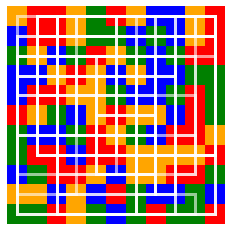

22 Colorings Iteration 0
16 Colorings Iteration 2
13 Colorings Iteration 5
10 Colorings Iteration 6
9 Colorings Iteration 7
5 Colorings Iteration 14
3 Colorings Iteration 16
1 Colorings Iteration 17
0 Colorings Iteration 19
Found a Rectangle Free Square in 20 iterations


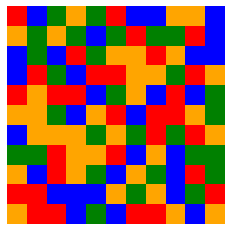

In [4]:
if show_movie:
    %matplotlib notebook
    from celluloid import Camera
else:
    %matplotlib inline

matches = checkAllRectangles(grid)
if not show_movie:
    print(f"Initial grid has {len(matches)} rectangles")
    displayGrid(grid, matches)
fewest_colorings = len(checkAllRectangles(grid))
max_i = 1000 * (max(grid.shape)**2)
i = 0

# # Movie Making
if show_movie:
    fig, ax = plt.subplots()
    camera = Camera(fig)

while (len(matches) > 0) and (i <= max_i):
    # fix all the current colorings
    grid = fixColorings(grid, matches)
    # find the new issues
    matches = checkAllRectangles(grid)
    
    if show_movie:
        displayGrid(grid, matches, ax=ax)
        ax.text(N-1, -1, f"Iteration: {i}", color="black", ha="right")
        if matches:
            ax.text(0, -1, f"Rectangles: {len(matches)}", color="black")
        else:
            ax.text(0, -1, "No Rectangles!", color="black")
        camera.snap()
    
    if len(matches) < fewest_colorings:
        print(len(matches), "Colorings", "Iteration", i)
        fewest_colorings = len(matches)
    if (i % 1000 == 0) and (not show_movie) and (i!=0):
        print(len(matches), "Colorings", "Iteration", i)
        displayGrid(grid, matches)
    i += 1

if (i==max_i) and matches:
    print(f"Failed to find a rectangle free square within {i} iterations")
if (not matches) and (not show_movie):
    print(f"Found a Rectangle Free Square in {i} iterations")
    displayGrid(grid, matches)
if show_movie:
    animation = camera.animate(interval=300, blit=True, repeat=False)